# Multimodal Integration
COMP386 Final Project by Angie Georgaras. Code for modalities adapted from projects completed by students in Dr. Albert's Fall COMP386 class. 

In [170]:
#packages used throughout the notebook
import numpy as np
import pylab as py #for plotting 
%matplotlib inline 
#shows plots in notebook
from IPython.display import Image, Audio
import math
import sklearn.decomposition #for ICA and PCA algorithms 
import PIL
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import pylab
from scipy import ndimage
import wave
import sys
import random as random

# Background and Motivation

We are constantly taking in sensory information, across several different modalities. For the purposes of this assignment I am going to focus on black and white images, color images, and sounds. 


The initial route that visual and auditory info travels into our brains differs. For vision, we take in info through the eyes, down the optic nerve, then to the optic chiasm, then to the lateral geniculate nucleus, and then to the first place in the cortex that visual info is processed: in the primary visual cortex. (V1)

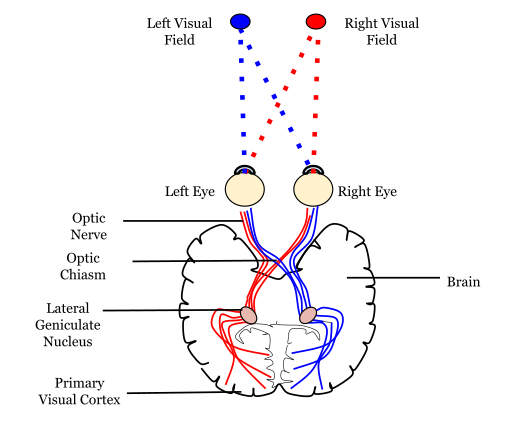

In [2]:
Image(filename="v1.png")

In V1 simple cells, we see a specific filter response to images. Particularly, this response is of a 2D Gabor filter, which is sensitive to planar sinusoids of specific locations, orientations, spatial frequencies, and phases.  
Below are two V1 filters that respond to different patterns of input.

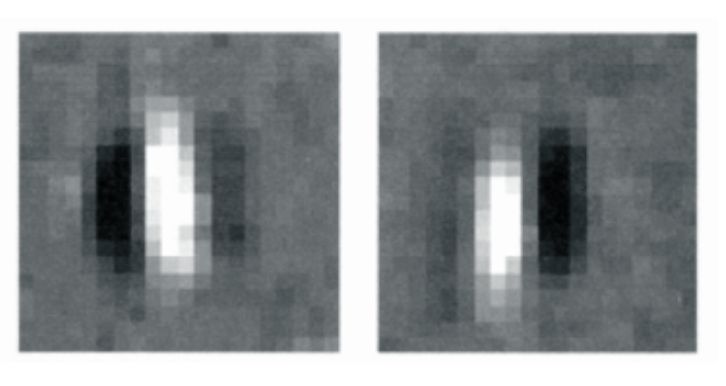

In [197]:
Image(filename='gabor.png')

To better visualize what V1 simple cells are sensitive to, below is an example of a 2D gabor filter that is sensitive to vertical lines convolved over an image of a forest. This displays how a V1 simple cell that is sensitive to vertical lines would react.

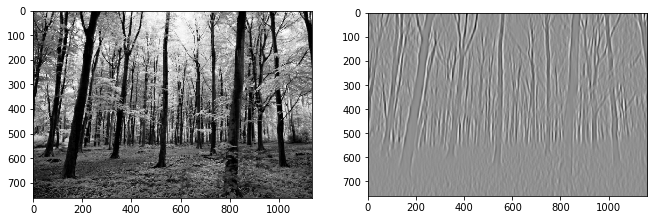

In [194]:
img_1 = mpimg.imread('tree.png')
img_2 = mpimg.imread('gabortree.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

For auditory info, we see sound go through the ear, through hair cells in the cochlea, to the first place sound is processed, which is done precortically in the auditory nerve. (spiral ganglion axons) 

Here, the filter response that we see is known as a gammatone filter, which is a linear filter thats produced by a gamma distribution and a sinusoidal tone. On the right is an example of what this would look like.

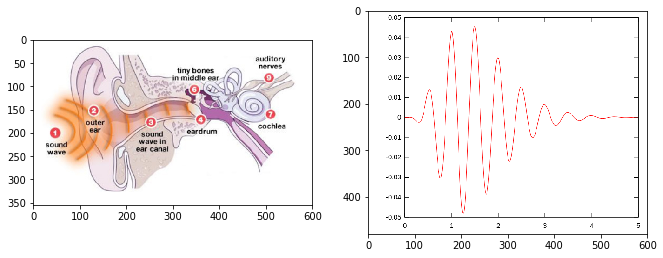

In [199]:
img_1 = mpimg.imread('ear.jpg')
img_2 = mpimg.imread('gamma.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

While different in name, the gammatone filter is strikingly similar to the 2D Gabor filter shown in V1 simple cells in that these specific shapes show that this info has been coded efficiently. This concept is known as the efficient coding hypothesis, which serves to explain how our brains represent and process sensory input. 

What do we mean when we say efficient? It depends on what we're looking at. For a computer, efficiency often means that 

# Black and White Images

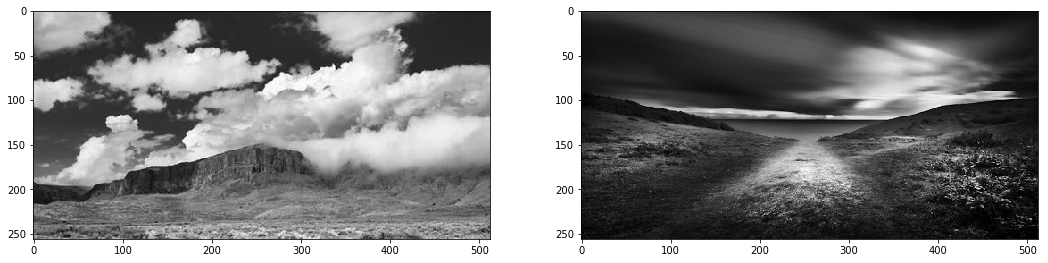

In [176]:
img_1 = mpimg.imread('BW/natural/1.jpg')
img_2 = mpimg.imread('BW/natural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

In [168]:
def collectPatches(numPatches, patchWidth):
    maxTries = numPatches * 50
    
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    
    imgPatches = np.zeros([numPixels,numPatches],'double')
                                                 
    # change the image sampled from
    imgCount = 1  
    image = PIL.Image.open('BW/natural/' + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/natural/' + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()
    
    # K, now I got the image, time to get patches
    
    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from
            imgCount += 1
            image = PIL.Image.open('BW/natural/' + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/natural/' + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
      
            firstPatch = patchCount
            firstTry = tryCount
    
            # update on every switch of images
            print (int(100 * float(patchCount)/numPatches),' percent complete')
        
        
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)

        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()

        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector    
            patch = np.reshape(patchSample, numPixels)     
            patch = patch - np.mean(patch)         
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1
            
    return imgPatches

patchesMat = collectPatches(50000, 16)
print('\nshape of the extracted image patch data:', patchesMat.shape)  

50  percent complete

shape of the extracted image patch data: (256, 50000)


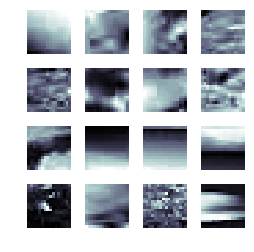

In [169]:
def showPatchesMat(prePatches, showPatchNum = 16, display=True):
    patches = prePatches

    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))

    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0,showPatchNum):
        patch_i = i * totalPatches // showPatchNum

        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()

    bw = 5    # border width
    pw = patchWidth

    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY

        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
        
    return

showPatchesMat(patchesMat)

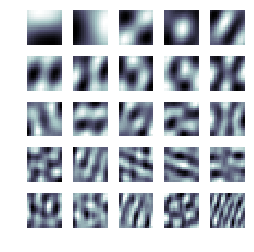

In [108]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patchesMat))

pca_comp = pcafit.components_
showPatchesMat(np.transpose(pca_comp), 25)

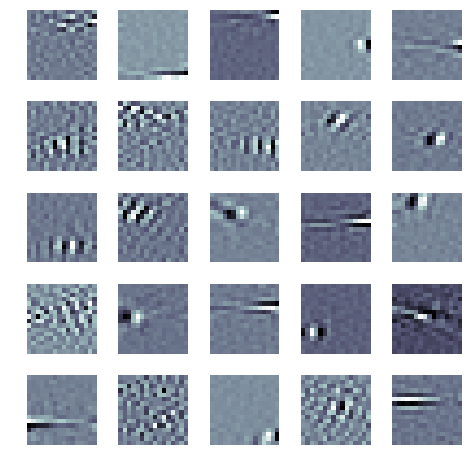

In [196]:
# finding ICA components

icatemp = sklearn.decomposition.FastICA(n_components=175)
icafit = icatemp.fit(np.transpose(patchesMat))

ica_comp = icafit.components_

showPatchesMat(np.transpose(ica_comp), 25)

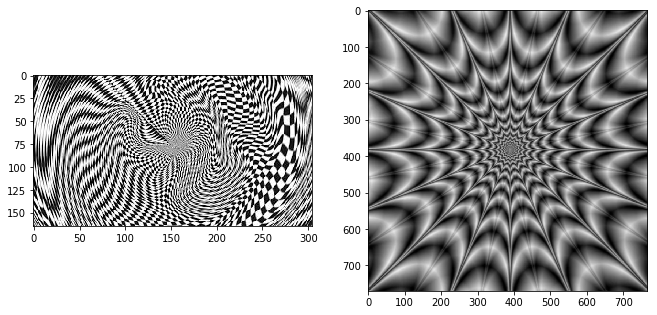

In [180]:
img_1 = mpimg.imread('BW/unnatural/1.jpg')
img_2 = mpimg.imread('BW/unnatural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);
    

In [17]:
def collectPatches(numPatches, patchWidth):
    maxTries = numPatches * 50
    
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    
    imgPatches = np.zeros([numPixels,numPatches],'double')
                                                 
    # change the image sampled from
    imgCount = 1  
    image = PIL.Image.open('BW/unnatural/' + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/unnatural/' + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()
    
    # K, now I got the image, time to get patches
    
    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from
            imgCount += 1
            image = PIL.Image.open('BW/unnatural/' + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread('BW/unnatural/' + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
      
            firstPatch = patchCount
            firstTry = tryCount
    
            # update on every switch of images
            print (int(100 * float(patchCount)/numPatches),' percent complete')
        
        
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)

        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()

        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector    
            patch = np.reshape(patchSample, numPixels)     
            patch = patch - np.mean(patch)         
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1
            
    return imgPatches

patchesMat = collectPatches(50000, 16)
print('\nshape of the extracted image patch data:', patchesMat.shape) 

50  percent complete

shape of the extracted image patch data: (256, 50000)


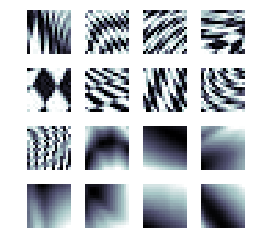

In [18]:
def showPatchesMat(prePatches, showPatchNum = 16, display=True):
    patches = prePatches

    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))

    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0,showPatchNum):
        patch_i = i * totalPatches // showPatchNum

        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()

    bw = 5    # border width
    pw = patchWidth

    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY

        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
        
    return

showPatchesMat(patchesMat)

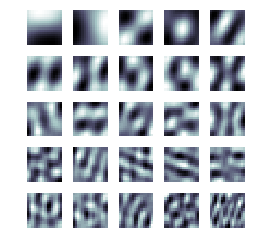

In [107]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patchesMat))

pca_comp = pcafit.components_
showPatchesMat(np.transpose(pca_comp), 25)

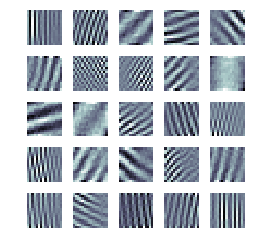

In [20]:
# finding ICA components

icatemp = sklearn.decomposition.FastICA(n_components=175)
icafit = icatemp.fit(np.transpose(patchesMat))

ica_comp = icafit.components_

showPatchesMat(np.transpose(ica_comp), 25)

# Color Images

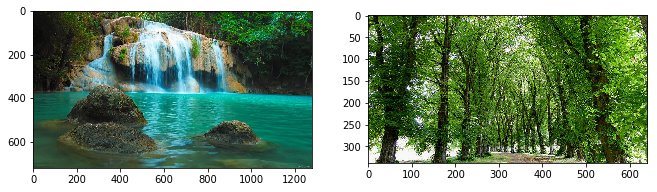

In [181]:
img_1 = mpimg.imread('color/natural/1.jpg')
img_2 = mpimg.imread('color/natural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);
    

Natural images patch sampling and display

In [83]:
def collect_natural_patches_c(num_patches = 100000, patch_width = 8):
  """ this function collects image patches from our natural image folder"""

  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = 3 * patch_width * patch_width

  patch_sample = np.zeros([3,patch_width,patch_width],float)
  patch = np.zeros([num_pixels],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # this changes the image we're sampling from
  nat_img_cnt = 1  
  image = PIL.Image.open('color/natural/' + str(nat_img_cnt) + '.jpg')
  image = np.asarray(image, 'double').transpose() 
  image = image[0:3,:,:]
  # normalizing the image
  image -= image.mean()
  image /= image.std()
  
  
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/2 or \
      (patch_cnt - img_first_patch) > num_patches/2: 
      nat_img_cnt += 1 #this switches to the next image we're sampling from!
      image = PIL.Image.open('color/natural/' + str(nat_img_cnt) + '.jpg')
      
      image = np.asarray(image, 'double').transpose() 
      image = image[0:3,:,:]
      
      
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')
    
    px = np.random.randint(0,image_width - patch_width)
    py = np.random.randint(0,image_width - patch_width)
        
    patch_sample = image[:,px:px+patch_width,py:py+patch_width].copy()
    
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)   
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat_c = collect_natural_patches_c(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat_c.shape)


50  percent complete

shape of the extracted image patch data: (192, 100000)


In [84]:
def show_patches_mat_c(pre_patches, show_patch_num = 16, display=True):
  """ this function generates a 2D array to display image patches (assuming square) """
  
  patches = pre_patches
    
  tot_patches = patches.shape[1]
  data_dim = patches.shape[0]
  patch_width = int(np.round(np.sqrt(data_dim))) - 6
  
  # extract show_patch_num patches
  disp_patch = np.zeros([data_dim, show_patch_num], float)
  for i in range(0,show_patch_num):
    patch_i = i * tot_patches // show_patch_num
  
    patch = patches[:,patch_i].copy()
    pmax  = patch.max()
    pmin = patch.min()
    
    # fix patch range from min to max to 0 to 1
    if pmax > pmin: 
      patch = (patch - pmin) / (pmax - pmin)
    disp_patch[:,i] = patch.copy()

  bw = 5    # border width
  pw = patch_width 
  
  patches_y = int(np.sqrt(show_patch_num))
  patches_x = int(np.ceil(float(show_patch_num) / patches_y))
  patch_img = disp_patch.max() * np.ones([3,(pw + bw) * patches_x - bw,
    patches_y * (pw + bw) - bw], float)
  for i in range(0,show_patch_num): 
    y_i = i // patches_y
    x_i = i % patches_y 
    #reshape patch sizing 
    reshaped = disp_patch[:,i].reshape((3,8,8))
    full_patch = np.zeros([3, pw, pw], float)
    full_patch[0:3,0:8,0:8] = reshaped[:,:,:].copy()
    patch_img[:,x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = full_patch
  
  if display:
    #displays the patches
    py.imshow(patch_img[:,:,:].T, interpolation='nearest') 
    py.axis('off')
  return

50  percent complete


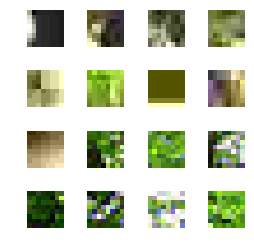

In [85]:
collect_natural_patches_c(num_patches = 100000, patch_width = 8)
show_patches_mat_c(patches_mat_c)
#this collects and displays our natural image patches that we'll run PCA and ICA on

Quality of image representation using only 40% as much data per patch 
(using only responses along these 10 components instead of the full 64 dimensions): 
 66.82889151784751 %

Percentage of data explained by each filter:
 [11.34642953  7.88176702  7.25423147  4.287384    3.47569521  3.01766298
  2.98956116  2.42399788  2.22732901  1.99476584  1.82153677  1.7062003
  1.67446048  1.55650942  1.43798327  1.38883073  1.37083694  1.27535138
  1.24723578  1.21321833  1.11647224  1.08103114  1.03380085  1.01997576
  0.98662405]


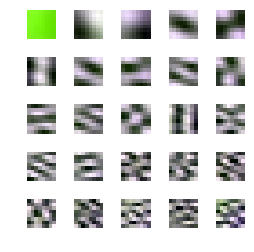

In [97]:
# finding PCA components 

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patches_mat_c))

print('Quality of image representation using only 40% as much data per patch',
      '\n(using only responses along these 10 components instead of the full 64 dimensions):',
      '\n',np.sum(100*pcafit.explained_variance_ratio_),'%')

print('\nPercentage of data explained by each filter:\n',100*pcafit.explained_variance_ratio_)

pca_comp = pcafit.components_
show_patches_mat_c(np.transpose(pca_comp), 25)


#this function finds 10 PCA components from these image patches
#PCA does not resemble receptive fields, its often used as preprocessing for ICA

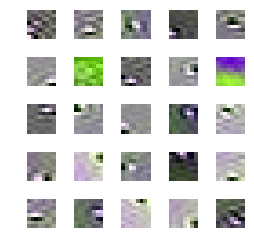

In [98]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=35) # note, sensitive to n_components
icafit_c = icatemp_c.fit(np.transpose(patches_mat_c))

ica_comp_c = icafit_c.components_

show_patches_mat_c(np.transpose(ica_comp_c), 25)
#these filters resemble receptive fields

Unnatural images patch sampling and display

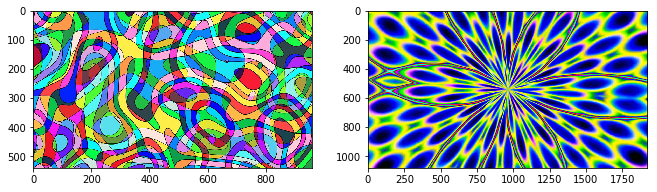

In [183]:
img_1 = mpimg.imread('color/unnatural/1.jpg')
img_2 = mpimg.imread('color/unnatural/2.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_1);
ax[1].imshow(img_2);

In [100]:
def collect_unnatural_patches_c(num_patches = 100000, patch_width = 8):
  """ this function collects image patches from our unnatural image folder"""

  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = 3 * patch_width * patch_width

  patch_sample = np.zeros([3,patch_width,patch_width],float)
  patch = np.zeros([num_pixels],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # change the image sampled from
  unnat_img_cnt = 3  
  image = PIL.Image.open('color/unnatural/' + str(unnat_img_cnt) + '.jpg')
  image = np.asarray(image, 'double').transpose() 
  image = image[0:3,:,:]
  # normalizing the image
  image -= image.mean()
  image /= image.std()
  
  
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/2 or \
      (patch_cnt - img_first_patch) > num_patches/2: 
      # change the image sampled from
      unnat_img_cnt += 1
      image = PIL.Image.open('color/unnatural/' + str(unnat_img_cnt) + '.jpg')
      
      image = np.asarray(image, 'double').transpose() 
      image = image[0:3,:,:]
      
      
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')
    
    px = np.random.randint(0,image_width - patch_width)
    py = np.random.randint(0,image_width - patch_width)
        
    patch_sample = image[:,px:px+patch_width,py:py+patch_width].copy()
    
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)   
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat_c = collect_unnatural_patches_c(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat_c.shape)

50  percent complete

shape of the extracted image patch data: (192, 100000)


50  percent complete


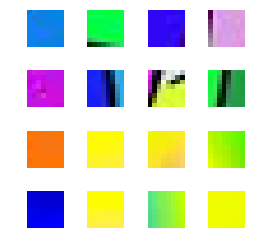

In [101]:
collect_unnatural_patches_c(num_patches = 100000, patch_width = 8)
show_patches_mat_c(patches_mat_c)
#this collects and shows our unnatural image patches that we'll run PCA and ICA on

Quality of image representation using only 40% as much data per patch 
(using only responses along these 10 components instead of the full 64 dimensions): 
 96.10003345241773 %

Percentage of data explained by each filter:
 [59.48687454 18.60864173  2.90011484  1.94560128  1.63792471  1.47692624
  1.19179991  1.08517482  0.99087632  0.85699957  0.74733817  0.65152881
  0.59410699  0.53803087  0.42283966  0.39554517  0.39138372  0.36067363
  0.31020994  0.29523317  0.28064906  0.26525723  0.23629928  0.23292906
  0.19707473]


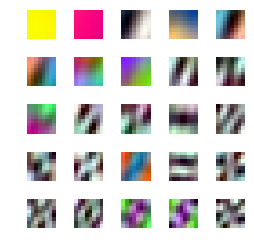

In [102]:
# finding PCA components, this section finds 10 components 

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patches_mat_c))

print('Quality of image representation using only 40% as much data per patch',
      '\n(using only responses along these 10 components instead of the full 64 dimensions):',
      '\n',np.sum(100*pcafit.explained_variance_ratio_),'%')

print('\nPercentage of data explained by each filter:\n',100*pcafit.explained_variance_ratio_)

pca_comp = pcafit.components_
show_patches_mat_c(np.transpose(pca_comp), 25) #this shows 25 patches in a 5 by 5 grid

#this function finds 10 PCA components from these image patches
#PCA does not resemble receptive fields, its often used as preprocessing for ICA

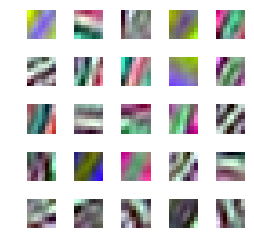

In [103]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=25) # note, sensitive to n_components
icafit_c = icatemp_c.fit(np.transpose(patches_mat_c))

ica_comp_c = icafit_c.components_

show_patches_mat_c(np.transpose(ica_comp_c), 25)

# Audio

In [156]:
Audio('audio/'+'dog.wav')

In [157]:
Audio('audio/'+'whitenoise.wav')

Sound Information:
Number of Samples: 445094
Hertz: 44100 Hz
Seconds: 10.09283446712018 seconds


/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


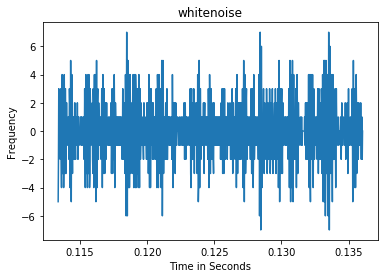

(100000, 1000)


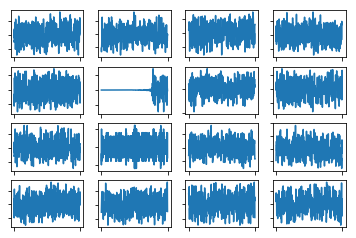

Sound Information:
Number of Samples: 170982
Hertz: 44100 Hz
Seconds: 3.8771428571428572 seconds


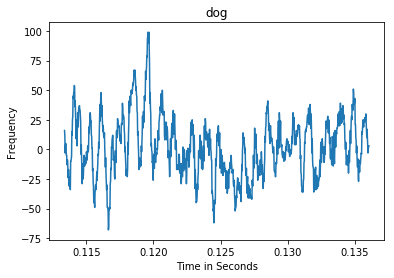

(100000, 1000)


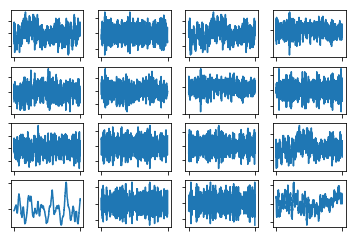

In [158]:
# opening the sound file


def load_audio(file):
    spf = wave.open('audio/' + file + '.wav','r')

    # extract raw audio from .wav file

    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    fs = spf.getframerate()

    # basic information printed 
    print('Sound Information:')
    print('Number of Samples:', len(signal))
    print('Hertz: %s Hz' % (fs))
    print('Seconds: %s seconds' %(len(signal)/fs))

    Time=np.linspace(0, len(signal)/fs, num=len(signal))

    # plot figure

    num_samples = len(signal)
    plt.figure(1)


    # titles
    plt.title(file)
    plt.xlabel('Time in Seconds')
    plt.ylabel('Frequency')
    start = 5000
    width = 1000
    plt.plot(Time[start:start+width],signal[start:start+width])
    plt.show()
    # plt.plot(Time, signal)

    # show figure

    plt.show()


    # making a matrix -- features by samples

    num_clips = 100000
    audio_clips = np.zeros((num_clips,width))
    for i in range(num_clips):
        x_start = np.random.randint(0,num_samples-width-2)
        audio_clips[i,:] = signal[x_start:x_start+width]


    print(audio_clips.shape)

    # show individual components

    plt.figure()
    cnt = 1
    for start in range(0,16000,1000):
        plt.subplot(4,4,cnt)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.plot(range(width),audio_clips[cnt,:])
        cnt += 1

    plt.show()

    return(audio_clips)

files = ['whitenoise', 'dog']
all_clips = []
for file in files:
    all_clips.append(load_audio(file))

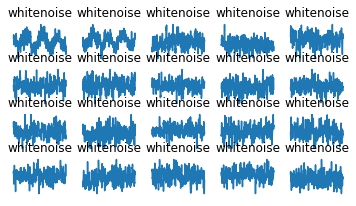

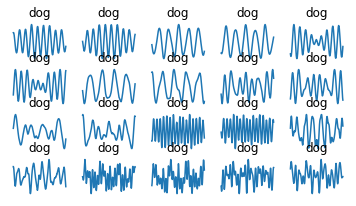

In [164]:
# finding PCA components
def pcaComponents(array, components=25):
    pcatemp = decomposition.PCA(n_components=components)
    return pcatemp.fit(array).components_

def getPCAComponents(audio_clips, file):
    pcacomp = pcaComponents(audio_clips)

    plt.figure()
    cnt = 0
    for cnt in range(20):
        plt.subplot(5, 5, cnt+1, title = file)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.axis("off")
        plt.plot(range(1000),pcacomp[cnt,:])
    plt.show()
    
for (i,each) in enumerate(all_clips):
    getPCAComponents(each, files[i])

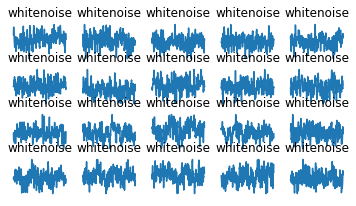

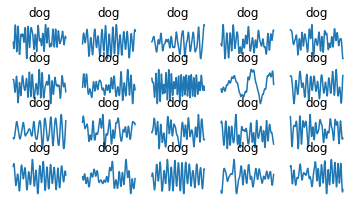

In [163]:
def icaComponents(array, components=25):
    icatemp = decomposition.FastICA(n_components=components)
    return icatemp.fit(array).components_

def getICAComponents(audio_clips, file):
    icacomp = icaComponents(audio_clips)

    plt.figure()
    cnt = 0
    for cnt in range(20):
        plt.subplot(5,5,cnt+1, title = file)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.axis("off")
        plt.plot(range(1000),icacomp[cnt,:])
    plt.show()
    
for (i,each) in enumerate(all_clips):
    getICAComponents(each, files[i])

# Side By Side Comparisons

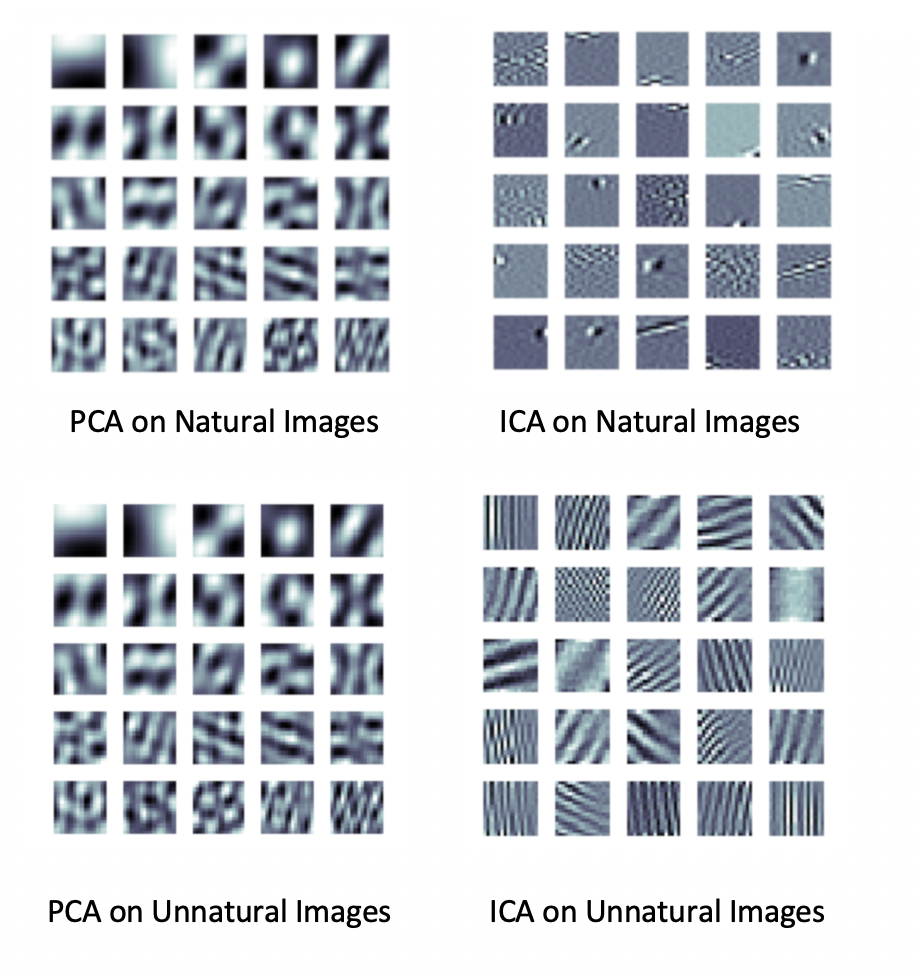

In [191]:
Image(filename="bwresults.png")

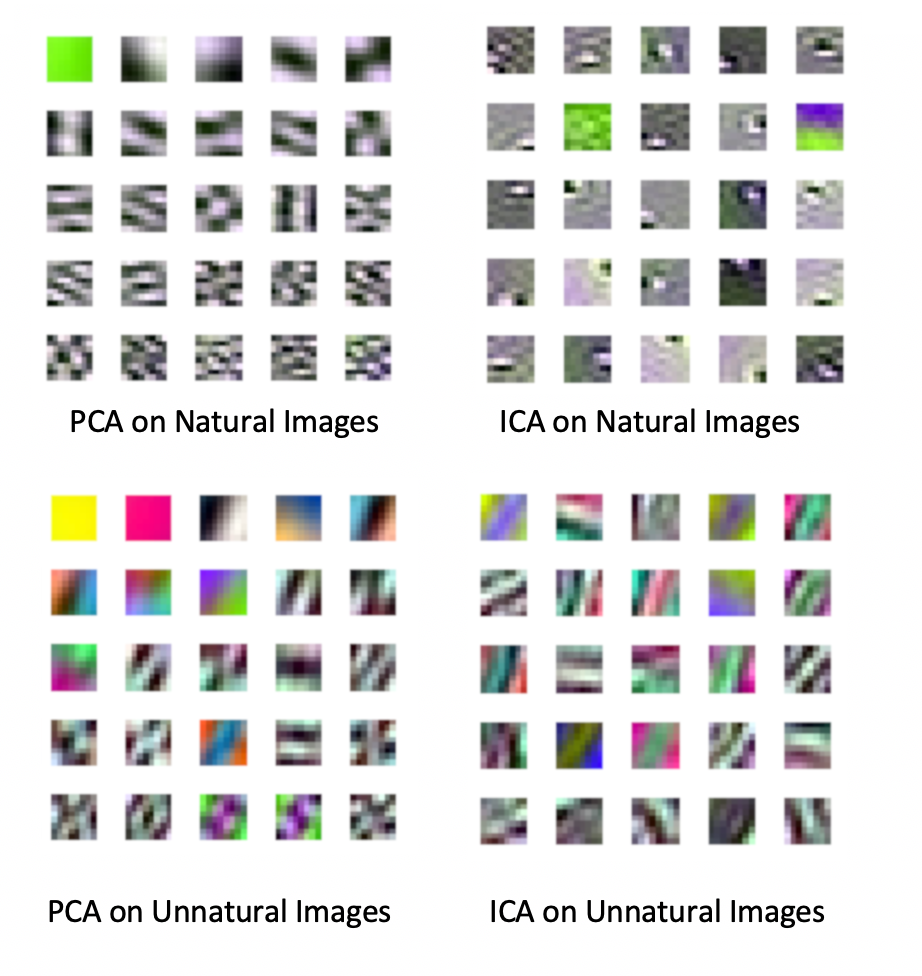

In [192]:
Image(filename="colorresults.png")

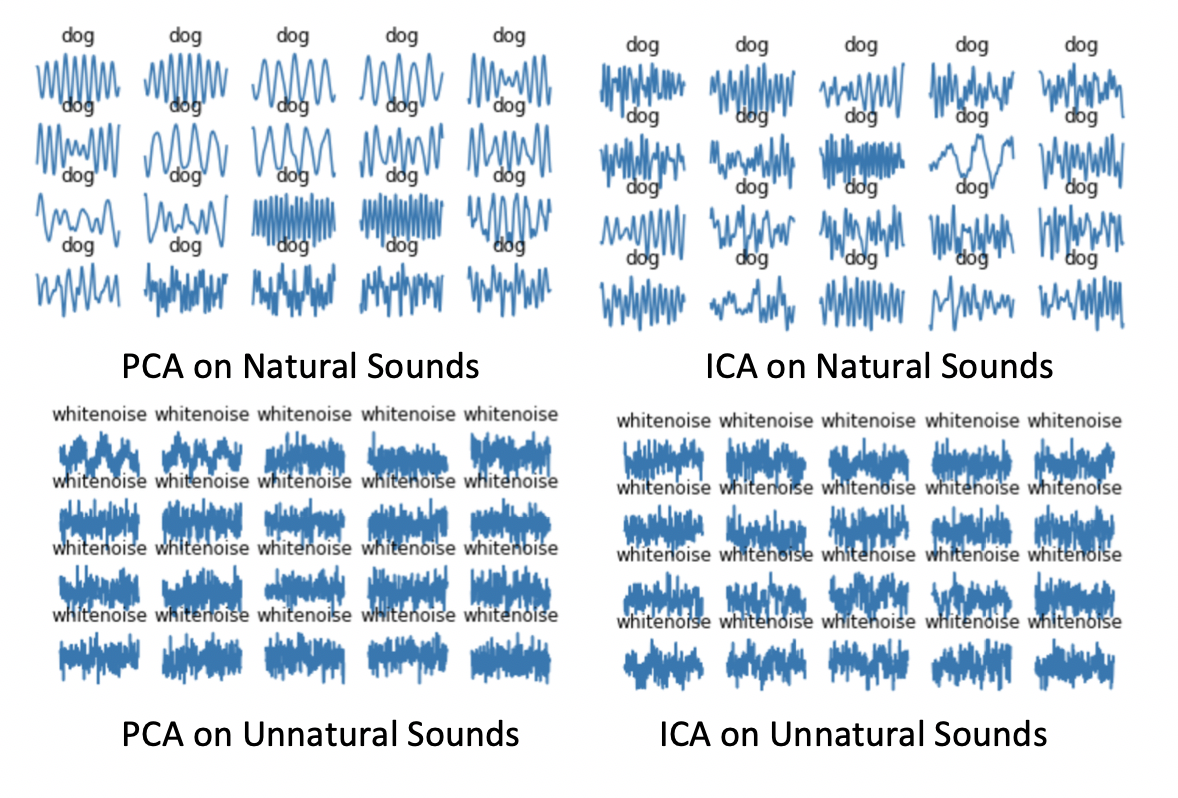

In [193]:
Image(filename="soundresults.png")